# Task
Analyze the provided medical chart embeddings and their corresponding ICD10 labels to train a multi-label classification model. The goal is to predict ICD10 codes for new embeddings, optimizing for the average micro-F2 score. The analysis should include data loading and preprocessing, exploratory data analysis with visualization, model selection and training, and model evaluation. Finally, generate predictions in the specified format and produce a report detailing the process and results. The data is provided in multiple files: "embedings_1.npy", "icd_codes_1.txt", "embedings_2.npy", and "icd_codes_2.txt". A sample submission file "sample_solution" is also provided.

## Data loading and preprocessing

### Subtask:
Load the embedding and label files. Convert the text labels into a multi-hot encoded vector representation. Combine the embeddings and multi-hot labels into a suitable format for model training.


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load embeddings - correcting the possible filename typo
try:
    embeddings_1 = np.load("embeddings_1.npy")
    embeddings_2 = np.load("embeddings_2.npy")
except FileNotFoundError:
    print("Could not find 'embeddings_1.npy' or 'embeddings_2.npy'. Please ensure the files are in the correct directory.")
    raise

# Load labels - assuming similar filename convention and removing 'squeeze'
try:
    labels_1 = pd.read_csv("icd_codes_1.txt", header=None)
    labels_2 = pd.read_csv("icd_codes_2.txt", header=None)
except FileNotFoundError:
    print("Could not find 'icd_codes_1.txt' or 'icd_codes_2.txt'. Please ensure the files are in the correct directory.")
    raise

# Concatenate embeddings and labels
all_embeddings = np.concatenate((embeddings_1, embeddings_2), axis=0)
# Access the single column of the dataframe after removing squeeze
all_labels = pd.concat((labels_1[0], labels_2[0]), axis=0)

# Split labels into lists of codes by splitting on ';'
all_labels_split = all_labels.apply(lambda x: x.split(';'))

# Initialize MultiLabelBinarizer and fit to all possible labels
mlb = MultiLabelBinarizer()
mlb.fit(all_labels_split)

# Transform labels into multi-hot encoded format
multi_hot_labels = mlb.transform(all_labels_split)

# Combine embeddings and multi-hot labels
training_data = (all_embeddings, multi_hot_labels)

print("Shape of combined embeddings:", all_embeddings.shape)
print("Shape of multi-hot encoded labels:", multi_hot_labels.shape)

Shape of combined embeddings: (198982, 1024)
Shape of multi-hot encoded labels: (198982, 1400)


## Exploratory data analysis (eda) and visualization

### Subtask:
Perform EDA to understand the data distribution, label frequencies, and potential correlations between features and labels. Visualize key aspects of the data.


Calculate the sum of each column in the `multi_hot_labels` array to get the counts for each label and then identify the most and least frequent ICD10 codes.



In [ ]:
# Calculate label frequencies
label_counts = np.sum(multi_hot_labels, axis=0)

# Get the list of ICD10 codes
icd10_codes = mlb.classes_

# Create a pandas Series for easier analysis
label_frequencies = pd.Series(label_counts, index=icd10_codes)

# Identify the most and least frequent codes
most_frequent_codes = label_frequencies.sort_values(ascending=False)
least_frequent_codes = label_frequencies.sort_values(ascending=True)

print("Most frequent ICD10 codes:")
display(most_frequent_codes.head())

print("\nLeast frequent ICD10 codes:")
display(least_frequent_codes.head())

Most frequent ICD10 codes:


,0
J35.01,2760
K40.90,2630
J35.03,2212
H66.93,2201
J35.3,1806



Least frequent ICD10 codes:


,0
Z98.890;Z85.3;Z90.13;Z42.1;L98.7,1
Z98.890;Z85.3;T85.42XA;Z90.13;N62;D24.1;N64.1;N65.0,1
Z98.890;Z85.3;D25.9;N80.03;N84.0;N95.0;N83.8;R93.89,1
A63.0;Z85.46,1
A63.0;Z85.048,1



Visualize the distribution of the top N most frequent labels using a bar plot to understand the label frequency distribution.



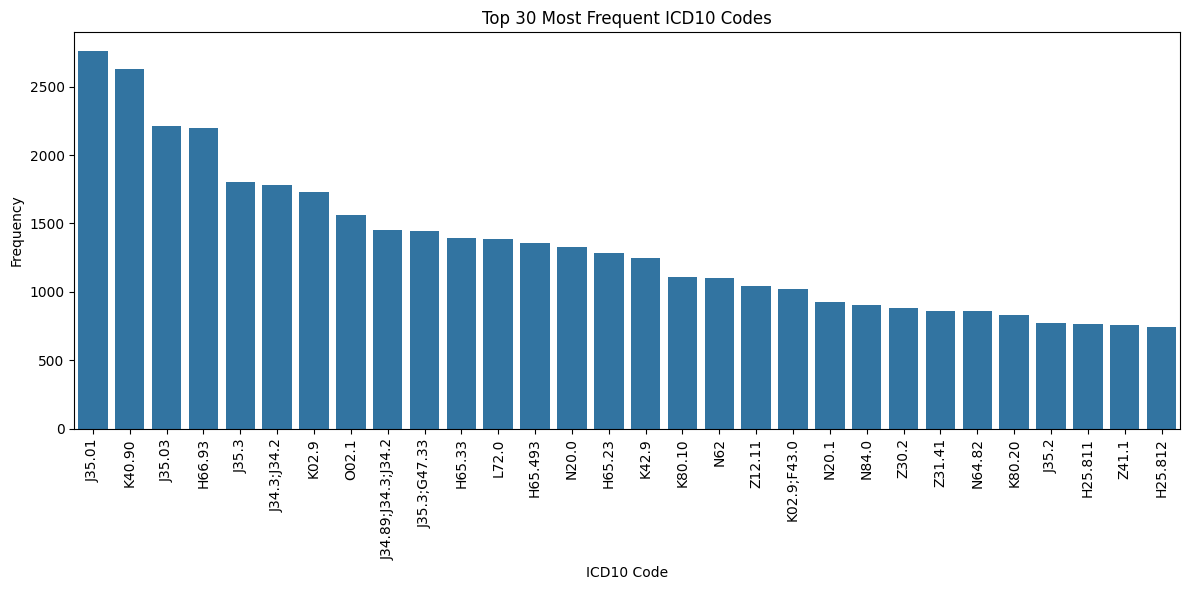

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the top 30 most frequent labels
top_n = 30
plt.figure(figsize=(12, 6))
sns.barplot(x=most_frequent_codes.head(top_n).index, y=most_frequent_codes.head(top_n).values)
plt.title(f'Top {top_n} Most Frequent ICD10 Codes')
plt.xlabel('ICD10 Code')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Calculate the number of labels per medical chart by summing each row of the multi-hot encoded labels and visualize the distribution using a histogram to understand the typical number of codes per chart.



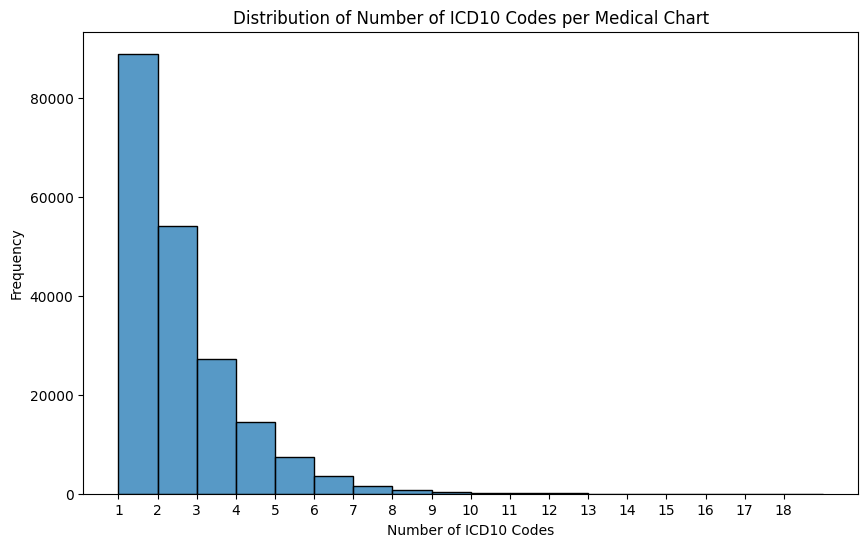

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of labels per medical chart
labels_per_chart = np.sum(multi_hot_labels, axis=1)

# Visualize the distribution of the number of labels per chart
plt.figure(figsize=(10, 6))
sns.histplot(labels_per_chart, bins=range(int(labels_per_chart.min()), int(labels_per_chart.max()) + 2), kde=False)
plt.title('Distribution of Number of ICD10 Codes per Medical Chart')
plt.xlabel('Number of ICD10 Codes')
plt.ylabel('Frequency')
plt.xticks(range(int(labels_per_chart.min()), int(labels_per_chart.max()) + 1))
plt.show()

### Subtask:
Perform dimensionality reduction on the embeddings and visualize them to explore potential clusters or patterns related to the labels.


Apply Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings for visualization purposes.

In [9]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions for visualization
# Let's reduce to 50 components initially to capture most variance before further reduction for plotting
n_components = 50
pca = PCA(n_components=n_components)
reduced_embeddings_pca = pca.fit_transform(all_embeddings)

print(f"Shape of embeddings after PCA to {n_components} components:", reduced_embeddings_pca.shape)

# Optional: Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Sum of explained variance ratio with {n_components} components:", np.sum(explained_variance_ratio))

Shape of embeddings after PCA to 50 components: (198982, 50)
Sum of explained variance ratio with 50 components: 0.52895916



Apply t-SNE to further reduce the dimensionality to 2 components for visualization, as PCA to a small number of components might not reveal non-linear relationships. Due to the large number of samples, we will use a subset of the data for t-SNE to keep computation time reasonable.

In [10]:
from sklearn.manifold import TSNE
import time

# Due to the large dataset size, let's use a subset for t-SNE visualization
subset_size = 5000
subset_indices = np.random.choice(reduced_embeddings_pca.shape[0], subset_size, replace=False)
reduced_embeddings_subset = reduced_embeddings_pca[subset_indices]
labels_subset = all_labels.iloc[subset_indices] # Use iloc for label subsetting

print(f"Shape of subset embeddings for t-SNE:", reduced_embeddings_subset.shape)

# Apply t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(reduced_embeddings_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

print("Shape of embeddings after t-SNE:", tsne_results.shape)

Shape of subset embeddings for t-SNE: (5000, 50)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.472s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.033926
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.281395
[t-SNE] KL divergence after 300 iterations: 2.132083
t-SNE done! Time elapsed: 16.3003032207489 seconds
Shape of embeddings after t-SNE: (5000, 2)



Visualize the t-SNE results. Since there are many unique labels, visualizing all of them simultaneously is not feasible. We will select a few of the most frequent labels to highlight in the plot to see if they form distinct clusters.

Top single labels to highlight in t-SNE plot: ['J35.01', 'K40.90', 'J35.03', 'H66.93', 'J35.3', 'N20.0', 'K02.9', 'O02.1', 'N62', 'H65.33']


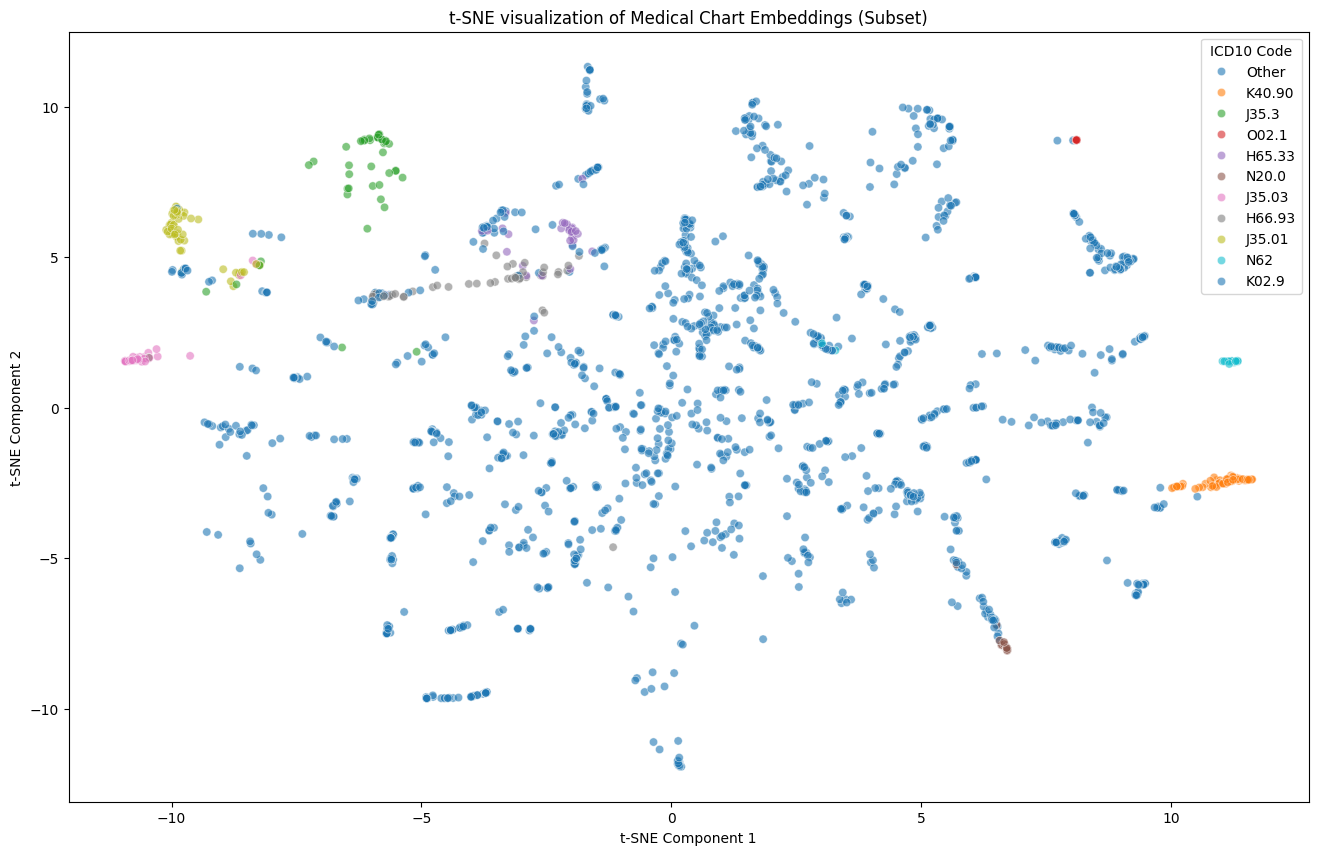

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the most frequent single labels to visualize
# We'll consider only single labels for simplicity in visualization
single_labels_subset = [label[0] for label in all_labels_split.iloc[subset_indices] if len(label) == 1]
single_labels_indices = [i for i in subset_indices if len(all_labels_split.iloc[i]) == 1]

# Filter t-SNE results and original labels for the subset with single labels
tsne_results_single = tsne_results[[i for i, original_index in enumerate(subset_indices) if original_index in single_labels_indices]]
original_labels_single = [all_labels_split.iloc[original_index][0] for original_index in subset_indices if original_index in single_labels_indices]


# Select a few of the most frequent single labels to highlight
# Get the counts of single labels in the subset
single_label_counts_subset = pd.Series(single_labels_subset).value_counts()
top_single_labels_to_highlight = single_label_counts_subset.head(10).index.tolist() # Select top 10 single labels

print("Top single labels to highlight in t-SNE plot:", top_single_labels_to_highlight)

# Create a list of labels for plotting: use the actual label if it's in the top_single_labels_to_highlight, otherwise use 'Other'
plot_labels = ['Other'] * len(tsne_results_single)
for i, label in enumerate(original_labels_single):
    if label in top_single_labels_to_highlight:
        plot_labels[i] = label

plt.figure(figsize=(16, 10))
sns.scatterplot(x=tsne_results_single[:,0], y=tsne_results_single[:,1], hue=plot_labels, palette='tab10', legend='full', alpha=0.6)
plt.title('t-SNE visualization of Medical Chart Embeddings (Subset)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='ICD10 Code')
plt.show()

## Data splitting

### Subtask:
Split the combined embeddings and multi-hot encoded labels into training and validation sets.


In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    all_embeddings, multi_hot_labels, test_size=0.2, random_state=42
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (159185, 1024)
Shape of X_val: (39797, 1024)
Shape of y_train: (159185, 1400)
Shape of y_val: (39797, 1400)


## Model selection

### Subtask:
Choose a suitable model for multi-label classification. Given the high dimensionality of embeddings and the multi-label nature, a neural network based approach or a method like One-vs-Rest with a linear model could be considered.



### Model Selection and Training

#### Potential Model Architectures for Multi-label Classification with High-Dimensional Embeddings

Given the high dimensionality of the input embeddings (1024 features) and the multi-label nature of the target variable (1400 possible classes, with each sample potentially having multiple labels), several model architectures could be considered:

1.  **Neural Networks:**
    *   **Pros:** Can learn complex non-linear relationships between high-dimensional input and multiple output labels. Architectures like feed-forward networks, or more advanced models, can be effective. They can handle the multi-label output directly with an appropriate output layer (e.g., sigmoid activation for each output neuron) and loss function (e.g., binary cross-entropy).
    *   **Cons:** Require significant computational resources and data for training. Can be prone to overfitting, especially with a large number of parameters. Model selection and hyperparameter tuning can be challenging.

2.  **One-vs-Rest (OvR) with Base Classifiers:**
    *   **Pros:** Simple and interpretable. Converts the multi-label problem into multiple independent binary classification problems (one for each label). Can leverage well-established binary classifiers (e.g., Logistic Regression, Support Vector Machines, or even simple neural networks). Training can be parallelized for each binary classifier.
    *   **Cons:** Ignores potential correlations between labels. The number of classifiers scales with the number of labels, which can be computationally expensive during prediction if the number of labels is very large. Performance can be suboptimal if label correlations are important for prediction.

3.  **Classifier Chains:**
    *   **Pros:** Models label correlations by building a sequence of binary classifiers where each subsequent classifier is trained on the original input features plus the predictions of the previous classifiers in the chain.
    *   **Cons:** The order of classifiers in the chain can significantly impact performance. Errors from early classifiers propagate down the chain. Can be computationally expensive to train due to the sequential nature.

4.  **Label Powerset:**
    *   **Pros:** Transforms the problem into a multi-class classification problem where each unique combination of labels in the training set is treated as a single class. Can capture label correlations.
    *   **Cons:** The number of unique label combinations can be very large, leading to a massive number of classes and potentially sparse training data for some combinations. Cannot predict label combinations not seen during training.

#### Chosen Model(s) and Appropriateness

Considering the dataset characteristics and the evaluation metric (average micro-F2), a **neural network based approach** is likely the most appropriate initial choice.

*   **Appropriateness:**
    *   **High-Dimensional Embeddings:** Neural networks are well-suited for learning from high-dimensional feature spaces like the provided embeddings.
    *   **Multi-label Classification:** With a sigmoid output layer and binary cross-entropy loss, a neural network can directly model the probability of each label being present independently, which aligns with the multi-label nature.
    *   **Average Micro-F2:** The micro-F2 score considers the total number of true positives, false negatives, and false positives across all labels. A neural network trained with binary cross-entropy, which optimizes for predicting the presence of each label, can be a good starting point for optimizing this metric. While not directly optimizing F2, a strong binary classification performance for each label generally contributes to a good micro-F2 score. More advanced techniques or loss functions could be explored later to directly address the F2 metric if needed.
    *   **Scalability:** Neural networks can scale well to large datasets.

As a strong baseline and a potentially competitive alternative, particularly if computational resources or training time become a significant constraint, **One-vs-Rest with a linear base classifier (like Logistic Regression)** is also a suitable consideration.

*   **Appropriateness:**
    *   **Simplicity and Speed:** OvR with Logistic Regression is relatively simple to implement and computationally less expensive than complex neural networks, especially during training (due to parallelization).
    *   **High-Dimensional Data:** Linear models like Logistic Regression can perform reasonably well on high-dimensional data, especially if the embeddings are informative.
    *   **Interpretability:** While less relevant for this task's objective, linear models offer some degree of interpretability.
    *   **Average Micro-F2:** OvR treats each label independently, and optimizing the performance of each binary classifier can contribute to a good micro-F2 score, similar to the neural network.

Given the preference for potentially capturing complex patterns and the power of deep learning on such data, the focus will initially be on a neural network model, but One-vs-Rest serves as a valuable benchmark and simpler alternative.

#### Basic Structure/Approach of Selected Model(s)

**Neural Network:**

The basic structure of a feed-forward neural network for this task would involve:

1.  **Input Layer:** Matches the dimension of the input embeddings (1024 neurons).
2.  **Hidden Layers:** One or more fully connected (dense) layers with activation functions (e.g., ReLU) to learn non-linear transformations of the input features. The number and size of hidden layers are hyperparameters to tune. Dropout layers can be included for regularization.
3.  **Output Layer:** A fully connected layer with a number of neurons equal to the total number of unique ICD10 codes (1400 neurons). Each neuron corresponds to a specific ICD10 code. A sigmoid activation function is applied to each output neuron to produce a probability score between 0 and 1, representing the likelihood of that label being present for the input embedding.
4.  **Loss Function:** Binary Cross-Entropy is commonly used for multi-label classification, calculated independently for each output neuron.
5.  **Optimizer:** An optimization algorithm (e.g., Adam) to update the model weights during training.

**One-vs-Rest with Logistic Regression (as a potential alternative/baseline):**

This approach involves training 1400 independent binary Logistic Regression classifiers.

1.  For each ICD10 code (label), a separate Logistic Regression model is trained.
2.  The input to each Logistic Regression model is the original 1024-dimensional embedding.
3.  The target for each Logistic Regression model is a binary variable indicating whether the specific ICD10 code is present (1) or absent (0) in the multi-hot encoded label vector.
4.  During prediction, each of the 1400 trained Logistic Regression models predicts the probability of its corresponding label being present.
5.  A threshold (e.g., 0.5) is applied to the predicted probabilities to determine which labels are predicted as present for a given input embedding.


## Model training

### Subtask:
Define and train a neural network model for multi-label classification using TensorFlow/Keras, including input and output layers with appropriate activation functions, compiling with Adam optimizer and binary cross-entropy loss, and training with validation data.


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the neural network model function
def create_model(input_dim, output_dim):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create an instance of the model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = create_model(input_dim, output_dim)

# Train the model
epochs = 10  # You can adjust the number of epochs
batch_size = 32 # You can adjust the batch size

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1
)

print("Model training finished.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 99s 19ms/step - accuracy: 0.3723 - loss: 0.0118 - val_accuracy: 0.5563 - val_loss: 0.0021
Epoch 2/10
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 140s 19ms/step - accuracy: 0.5465 - loss: 0.0024 - val_accuracy: 0.5757 - val_loss: 0.0020
Epoch 3/10
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 99s 20ms/step - accuracy: 0.5553 - loss: 0.0023 - val_accuracy: 0.5753 - val_loss: 0.0020
Epoch 4/10
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.5553 - loss: 0.0023 - val_accuracy: 0.5728 - val_loss: 0.0020
Epoch 5/10
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 143s 20ms/step - accuracy: 0.5577 - loss: 0.0023 - val_accuracy: 0.5736 - val_loss: 0.0020
Epoch 6/10
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 137s 19ms/step - accuracy: 0.5566 - loss: 0.0023 - val_accuracy: 0.5702 - val_loss: 0.0020
Epoch 7/10
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 98s 20ms/step - accuracy: 0.5573 - loss: 0.0023 - val_accuracy: 0.5569 - val_loss: 0.0021
Epoch 8/10
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.5

## Model evaluation

### Subtask:
Evaluate the trained model on the validation set using appropriate metrics, with a focus on the average micro-F2 score.

In [21]:
from sklearn.metrics import fbeta_score

# Predict probabilities on the validation set
y_pred_proba = model.predict(X_val)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
# We can experiment with different thresholds later to optimize for micro-F2
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)

# Calculate the micro-F2 score
# The fbeta_score function computes F-beta score.
# For F2, beta = 2. Setting average='micro' computes the micro-averaged F2 score.
micro_f2 = fbeta_score(y_val, y_pred, average='micro', beta=2)

print(f"Micro F2 Score on Validation Set: {micro_f2:.4f}")

# Optional: Print other metrics like accuracy
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
Micro F2 Score on Validation Set: 0.7315
Validation Loss: 0.0021
Validation Accuracy: 0.5624


## Prediction on Test Data

### Subtask:
Load the test embeddings from "test_data.npy" and use the trained neural network model to predict the multi-hot encoded labels.

In [22]:
# Load the test embeddings
try:
    test_embeddings = np.load("test_data.npy")
    print("Shape of test embeddings:", test_embeddings.shape)
except FileNotFoundError:
    print("Could not find 'test_data.npy'. Please ensure the file is in the correct directory.")
    raise

# Predict probabilities on the test set
test_pred_proba = model.predict(test_embeddings)

# Convert probabilities to binary predictions using the same threshold as validation
# We can potentially optimize this threshold later based on the F2 score on a held-out set
test_pred = (test_pred_proba > threshold).astype(int)

print("Shape of test predictions (multi-hot):", test_pred.shape)

Shape of test embeddings: (99490, 1024)
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step
Shape of test predictions (multi-hot): (99490, 1400)


## Generate Submission File

### Subtask:
Format the predictions into the specified submission file format ("sample_solution.csv").

In [23]:
# Convert multi-hot predictions back to label strings
# We need the mlb (MultiLabelBinarizer) object fitted on the training labels
# to inverse transform the predictions.
test_pred_labels = mlb.inverse_transform(test_pred)

# Format the labels as semicolon-separated strings
formatted_predictions = [';'.join(labels) for labels in test_pred_labels]

# Create a pandas DataFrame for the submission file
submission_df = pd.DataFrame({'ICD10_codes': formatted_predictions})

# Save the submission file in the specified format (no header, no index)
submission_df.to_csv("submission.csv", index=False, header=False)

print("Submission file 'submission.csv' generated successfully.")

Submission file 'submission.csv' generated successfully.
